(231, 10)
cpu


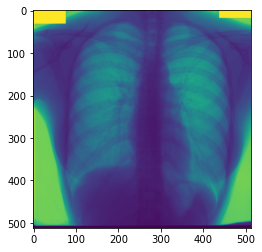

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math, re
import matplotlib.pyplot as plt


import torchvision.transforms as tvtransforms

# Torch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

# MTANN
import MTANN
from torchviz import make_dot
import datasets, transforms

flag_verbose = False

path_to_save = os.path.join('.')


# Data
root_directory = "D:/data/JSRT/"
path_to_source_images = os.path.join(root_directory, "JSRT")
path_to_target_images = os.path.join(root_directory, "BSE_JSRT")

image_spatial_size=(512,512)
key_source, key_boneless = "source", "boneless"
validation_test_length = 10

# Datasets
discriminator_keys_images = [key_source, key_boneless]
ds = datasets.JSRT_CXR( path_to_source_images, path_to_target_images, 
                       transform=tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images),
                             ]))
lengths=(len(ds)-validation_test_length, validation_test_length)
print(lengths)
ds_training, ds_val = random_split(ds, lengths)

fixed_sample = next(iter(ds_val))
plt.imshow(fixed_sample[key_source])

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available() and ngpu > 0):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [2]:
# Networks
netHR = MTANN.linearOutputANN(first_layer=81, second_layer=20)
netMR = MTANN.linearOutputANN(first_layer=81, second_layer=20)
netLR = MTANN.linearOutputANN(first_layer=81, second_layer=20)
# Loss
criterion = nn.L1Loss()
# Optimiser
optimiserHR = optim.SGD(netHR.parameters(), lr=0.001)
optimiserMR = optim.SGD(netMR.parameters(), lr=0.001)
optimiserLR = optim.SGD(netLR.parameters(), lr=0.001)

AttributeError: cannot assign parameters before Module.__init__() call

In [ ]:
from skimage.metrics import structural_similarity as ssim

ovs = MTANN.OverlappingSubregions(key_source, key_boneless,9,1)

iters, flag_break = 0,False
reals_shown = 0
ssim_list = []
for sample_count, sample in enumerate(ds_training):
    
    if sample_count > 3:
        print("Complete debugging")
        break
    
    preprocessing = MTANN.dataPreprocessing(sample, discriminator_keys_images)
    
    iters=0
    for ii, data in enumerate(ovs.execute(preprocessing.LR)):
        # Subregions are the training data input
        # Target_pixels are the training data target outputs
        subregion, target_pixel, center_pixel = data
        
        optimiserLR.zero_grad()
        outputs = netLR(subregion)
        loss = criterion(outputs, target_pixel)
        loss.backward()
        optimiserLR.step()
        iters+=1
    reals_shown += iters
    if flag_verbose:
        print("LR Training Complete.")
        print("Reals shown: {}".format(reals_shown))
    MTANN.save_model(os.path.join(path_to_save,'netLR.pt'), netLR, optimiserLR, loss, reals_shown)
    
    iters=0
    for ii, data in enumerate(ovs.execute(preprocessing.MR)):
        # Subregions are the training data input
        # Target_pixels are the training data target outputs
        subregion, target_pixel, center_pixel = data
        
        optimiserMR.zero_grad()
        outputs = netMR(subregion)
        loss = criterion(outputs, target_pixel)
        loss.backward()
        optimiserMR.step()
        iters+=1
    reals_shown += iters
    if flag_verbose:
        print("MR Training Complete.")
        print("Reals shown: {}".format(reals_shown))
    MTANN.save_model(os.path.join(path_to_save,'netMR.pt'), netMR, optimiserMR, loss, reals_shown)
    
    iters = 0
    for ii, data in enumerate(ovs.execute(preprocessing.HR)):
        # Subregions are the training data input
        # Target_pixels are the training data target outputs
        subregion, target_pixel, center_pixel = data
        
        optimiserHR.zero_grad()
        outputs = netHR(subregion)
        loss = criterion(outputs, target_pixel)
        loss.backward()
        optimiserHR.step()
        iters+=1
    reals_shown += iters
    if flag_verbose:
        print("HR Training Complete.")
        print("Reals shown: {}".format(reals_shown))
    MTANN.save_model(os.path.join(path_to_save,'netHR.pt'), netHR, optimiserHR, loss, reals_shown)
    
    print("Number of radiology images trained on: {} ; number of reals shown: {}".format(sample_count, reals_shown))
    
    # Reconstruction of images to validate
    validation_sample = next(iter(ds_val))
    reconstruction = MTANN.ImageReconstruction(validation_sample, key_source, key_boneless=None, matrix_size=9, stride=1)
    image, image_from_LR , image_from_MR , image_from_HR = reconstruction.reconstruct_multiresolution(netHR, netMR, netLR)
    image = (image - np.amin(image))/(np.amax(image) - np.amin(image)) # rescale to [0,1]
    ssim_list.append(ssim(image, validation_sample[key_boneless]))

In [ ]:
output_save_directory = "."
plt.plot(ssim_list)
plt.title("SSIM")
plt.xlabel("Radiography Images Shown")
plt.ylabel("SSIM")
plt.savefig(os.path.join(output_save_directory, "SSIM"+".png"))

In [ ]:
a = np.zeros((5,5))
a = np.pad(a,2)
print(a.shape)